# Model and Training Customization


In this tutorial the goal is to see how we can create more sophisticated models and more complicated training schemes.

First, let's load the libraries.

In [ ]:
!pip install lightning

  Using cached lightning-2.4.0-py3-none-any.whl.metadata (38 kB)
  Using cached lightning_utilities-0.11.8-py3-none-any.whl.metadata (5.2 kB)
  Using cached torchmetrics-1.5.1-py3-none-any.whl.metadata (20 kB)
  Using cached pytorch_lightning-2.4.0-py3-none-any.whl.metadata (21 kB)
Using cached lightning-2.4.0-py3-none-any.whl (810 kB)
Using cached lightning_utilities-0.11.8-py3-none-any.whl (26 kB)
Using cached torchmetrics-1.5.1-py3-none-any.whl (890 kB)
Using cached pytorch_lightning-2.4.0-py3-none-any.whl (815 kB)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics.classification as metrics

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

%matplotlib inline

We'll work on the same dummy dataset as we did in the previous tutorial.

In [ ]:
np.random.seed(13)

X, y = make_moons(300, noise=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

######################################################################
############################## PLOTTING ##############################
######################################################################

def visualize_decision_boundary(model):
    """
    Helper function that visualizes a model's decision boundary on the
    previously defined moons dataset
    """
    # Find out where to start and end the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    # Generate the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05, dtype=np.float32),
                         np.arange(y_min, y_max, 0.05, dtype=np.float32))

    # Generate predictions for each point of the mesh
    model.eval()
    with torch.no_grad():
        mesh_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
        mesh_preds = model(mesh_tensor).numpy()

    # We'll also create a custom diverging colormap from blue to orange.
    # Details here:
    # https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

    blue = matplotlib.colormaps['Blues']
    orange = matplotlib.colormaps['Oranges_r']

    color_array = np.vstack((blue(np.linspace(0, 1, 128)),
                             orange(np.linspace(0, 1, 128))))

    BuOr = matplotlib.colors.ListedColormap(color_array)

    # Create the figure
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)

    # Draw the mesh predictions as contours
    ax.contourf(xx, yy, mesh_preds.reshape(xx.shape), cmap=BuOr, alpha=0.4)

    # Draw the data points in their actual colors
    colors = ['C' + str(int(i)) for i in y_test]
    ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)

    ax.axis('off')
    ax.set_title('Test set samples and predictions')


plt.figure(figsize=(16, 6))

ax = plt.subplot(121)
colors = ['C' + str(i) for i in y_train]
ax.scatter(X_train[:, 0], X_train[:, 1], c=colors)
ax.axis('off')
ax.set_title('Training set')

ax = plt.subplot(122)
colors = ['C' + str(i) for i in y_test]
ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)
ax.axis('off')
ax.set_title('Test set');

## Refined metric logging

First of all let's start with a few easy improvements on our MLP from the previous tutorial. The main I want to do is to add more metrics and refine the way we log them.

Before we proceed we need to know a few more things about torch metrics. When tracking model performance during training, there are two main ways to log metrics: logging at a **batch-level** (i.e. at each step) or at an **epoch-level** (i.e. end of each epoch).

- A batch-level logging simply means that we compute the metrics at each step and log them. This might seem like the default approach, however we should note that some metrics are inherently **noisy**, which makes it very hard to determine the trend in which they are evolving.

- An epoch-level logging alleviates theis noise by keeping track of a moving average of the metrics for each batch and logging them at the end of the epoch.

The most common thing for training metrics is to log them **both** at a batch and an epoch level (most importantly at a batch-level, though, to see how training progresses). On the other hand, validation metrics are logged always at an epoch level (we don't care how each batch of the validation set performs, rather how the whole dataset does).

In [ ]:
class MultiLayerPerceptron(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        # Define NN components
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

        # Define metrics
        self.accuracy = metrics.BinaryAccuracy()
        self.precision = metrics.BinaryPrecision()
        self.recall = metrics.BinaryRecall()
        self.f1_score = metrics.BinaryF1Score()
        self.auroc = metrics.BinaryAUROC()

    def forward(self, x):
        """
        Define the forward propagation of the model
        """
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

    def training_step(self, batch, batch_idx):
        """
        Define what happens in each step of the training loop
        """

        # Forward propagation
        x, y = batch
        preds = self(x)

        # Compute and log metrics
        metrics = {f'train_{name}': value for name, value in self.compute_metrics(preds, y).items()}

        self.log_dict(metrics,           # dictionary with the metrics we want to log
                      on_step=True,      # if True, will log current step
                      on_epoch=True,     # if True, will log accumulated metric at the end of the epoch
                      prog_bar=True)     # if True, will log to the progress bar

        # Return results
        metrics['loss'] = metrics['train_loss']  # return dict must necessarily include the loss tensor with the key 'loss'
        return metrics


    def validation_step(self, batch, batch_idx):
        """
        Define what happens in each step of the validation loop
        """

        # Forward propagation
        x, y = batch
        preds = self(x)

        # Compute and log metrics
        metrics = {f'val_{name}': value for name, value in self.compute_metrics(preds, y).items()}
        self.log_dict(metrics, on_epoch=True, prog_bar=True)

        return metrics

    def configure_optimizers(self, lr=0.1):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        return optimizer

    def compute_metrics(self, preds, targets):
        """
        Compute loss and all metrics on a set of predictions
        """

        binary_preds = self.preds_to_binary(preds)
        metrics = {
            'loss': F.binary_cross_entropy(preds, targets),
            'accuracy': self.accuracy(binary_preds, targets),
            'precision': self.precision(binary_preds, targets),
            'recall': self.recall(binary_preds, targets),
            'f1_score': self.f1_score(binary_preds, targets),
            'AUROC': self.auroc(binary_preds, targets)
        }
        return metrics

    @staticmethod
    def preds_to_binary(preds):
        """
        Helper function to convert all preds to
        """
        return (preds >= 0.5).int()


mlp = MultiLayerPerceptron(input_dim=2, hidden_dim=30, output_dim=1)

Let's create our datasets and train our model. One different thing we'll do than before is to add a validation dataloader during `Trainer.fit()`. This will automatically use this dataloader for validation after each epoch.

In [ ]:
# Create the training set data loader
x_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(x_tensor, y_tensor.unsqueeze(1))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create the validation set data loader
x_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.unsqueeze(1))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Define the trainer
trainer = L.Trainer(max_epochs=50)

# Train the model
trainer.fit(model=mlp,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | hidden    | Linear          | 90     | train
1 | output    | Linear          | 31     | train
2 | sigmoid   | Sigmoid         | 0      | train
3 | relu      | ReLU            | 0      | train
4 | accuracy  | BinaryAccuracy  | 0      | train
5 | precision | BinaryPrecision | 0      | train
6 | recall    | BinaryRecall    | 0      | train
7 | f1_score  | BinaryF1Score   | 0      | train
8 | auroc     | BinaryAUROC     | 0      | train
------------------------------------------------------
121       Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


We can look at the last values logged in the trainer:

In [ ]:
trainer.logged_metrics

{'train_loss_step': tensor(0.1972),
 'train_accuracy_step': tensor(1.),
 'train_precision_step': tensor(1.),
 'train_recall_step': tensor(1.),
 'train_f1_score_step': tensor(1.),
 'train_AUROC_step': tensor(1.),
 'val_loss': tensor(0.2266),
 'val_accuracy': tensor(0.9091),
 'val_precision': tensor(0.8502),
 'val_recall': tensor(0.9461),
 'val_f1_score': tensor(0.8953),
 'val_AUROC': tensor(0.9078),
 'train_loss_epoch': tensor(0.2343),
 'train_accuracy_epoch': tensor(0.8806),
 'train_precision_epoch': tensor(0.8658),
 'train_recall_epoch': tensor(0.8954),
 'train_f1_score_epoch': tensor(0.8789),
 'train_AUROC_epoch': tensor(0.8761)}

Or visualize the decision boundary like we did in the previous tutorial.

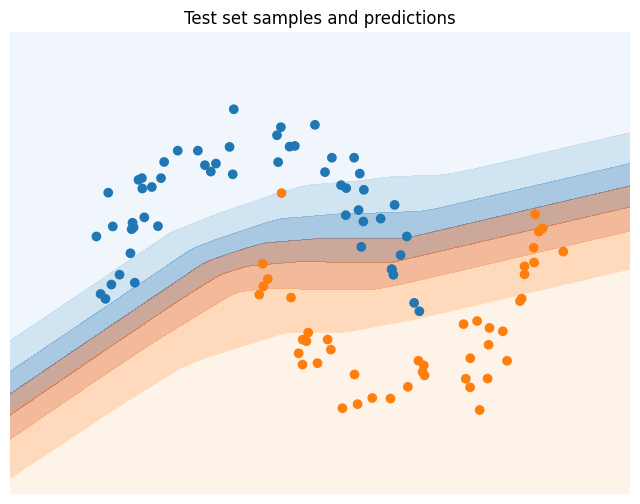

In [ ]:
visualize_decision_boundary(mlp)

Now we'll focus on a few components that actually affect the model's training.

## Loss Function

We'll start by arguably the most important component. The choice of the loss function is actually not up to us most of the times; rather it's defined by the task we have to solve. Usually we choose the most popular loss for the desired task.

Up till now, we've been using a [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy), which should be the default choice for any **classification** task:

$$
J(y, \hat y) = - \sum_{i=1}^N y_i \cdot \log \hat y_i
$$

where $N$ is the number of samples in the sets $y$ and $\hat y$.

In practice we have two versions of this loss:
- binary cross-entropy for **binary classification** problems: [`torch.nn.functional.binary_cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html#torch.nn.functional.binary_cross_entropy)
- regular cross-entropy for **multiclass classification** problems: [`torch.nn.functional.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

If you want to learn more about what this function actually does, you can read [this blog post](http://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/).

If we have a **regression** task, we should start with using a **Mean Squared Error** loss:

$$
J(y, \hat y) = \frac{1}{N}\sum_{i=1}^N{(y - \hat y)^2}
$$

In torch this is [`torch.nn.functional.mse_loss`](https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html#torch.nn.functional.mse_loss).

While these three are the main loss functions that we'll use 99% of the time, there are a lot more losses implemented for more specific use cases. You can find a list of all available losses [here](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) and it is possible to define our own custom loss.  

## Optimizers

One thing that was very noticable fron the 1st tutorial was the very slow convergence speeds. One thing we could try would be to increase the **learning rate** or even add a bit of **momentum** to the optimizer.

We started using SGD since it the most "vanilla" optimization strategy we could choose. However, in practice, we would probably want to start out with a more advanced algorithm, like [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam).

Besides these two pytorch has a lot more optimizers to choose from. You can find the list of available optimizers [here](https://pytorch.org/docs/stable/optim.html#algorithms). We won't cover the different optimizers or their hyperparameters here. If you want to learn more about optimizers, an excellent overview can be found [here](https://ruder.io/optimizing-gradient-descent/).

In [ ]:
class MultiLayerPerceptronAdam(MultiLayerPerceptron):

    def configure_optimizers(self, lr=0.01):
        """
        This method is used to set up the optimizer(s) used by our model
        """
        optimizer = optim.Adam(self.parameters(), lr=lr)
        return optimizer


mlp_adam = MultiLayerPerceptronAdam(input_dim=2, hidden_dim=30, output_dim=1)

In [ ]:
trainer = L.Trainer(max_epochs=50)

trainer.fit(model=mlp_adam,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

print(f'Validation accuracy: {trainer.logged_metrics["val_accuracy"]*100:.2f}%')

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | hidden    | Linear          | 90     | train
1 | output    | Linear          | 31     | train
2 | sigmoid   | Sigmoid         | 0      | train
3 | relu      | ReLU            | 0      | train
4 | accuracy  | BinaryAccuracy  | 0      | train
5 | precision | BinaryPrecision | 0      | train
6 | recall    | BinaryRecall    | 0      | train
7 | f1_score  | BinaryF1Score   | 0      | train
8 | auroc     | BinaryAUROC     | 0      | train
------------------------------------------------------
121       Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Validation accuracy: 96.97%


We got a much quicker convergence with this configuration. If you're interested in seeing how the different optimizers and LR configurations compare to each other in this problem you can see the figure below:

![](https://github.com/djib2011/tensorflow-training/blob/main/figures/optimizer_comparison.png?raw=true)

A couple of things to be aware of:
1. The best optimizer configuration depends on the problem we want to solve. Because we happened to get a better performance off of Adam with $lr=0.1$, this doesn't mean that this will be the case for every task.
2. Different optimizers have different values for their parameters. For instance SGD has a default learning rate of $0.01$, while Adam, which is by much faster, has a default learning rate of $0.001$. Keep this in mind when you are hyper-parameter tuning these components. Not all values are suitable for all optimizers.

Let's visualize our trained model's decision boundary.

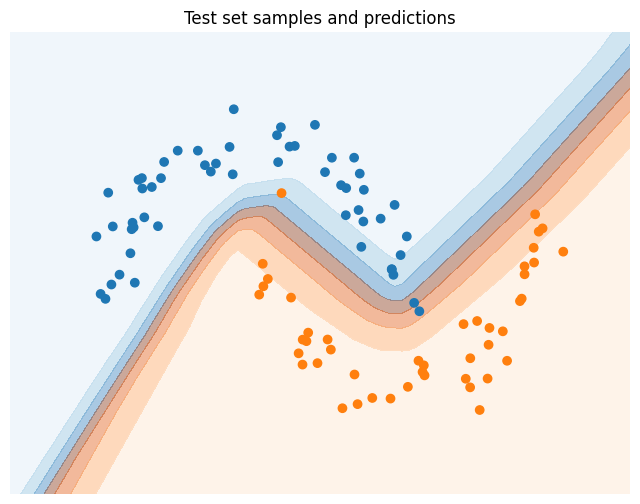

In [ ]:
visualize_decision_boundary(mlp_adam)

Unfortunately, we can't do much better than the above ;) We'll continue investigating the different things we can customize in the model's architecture and training, even if we aren't driven by performance anymore.

## Learning Rate schedulers

A lot of times we don't want to run the whole training with a constant learning rate. However, since Lightning abstracts the training loop (i.e. when we call `Trainer.fit()` it handles all the training for us), we don't have a straightforward mechanism for manually changing the learning rate whenever we want. To solve this, we'll define a **scheduler**, i.e. strategy based on which the LR will be modified and provide this scheduler to Lightning.

Let's try an [exponentially decaying LR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR) strategy. This strategy scales the LR at each epoch by a factor called `gamma`. To better visualize how the LR changes with this scheduler we can look at the plot below:




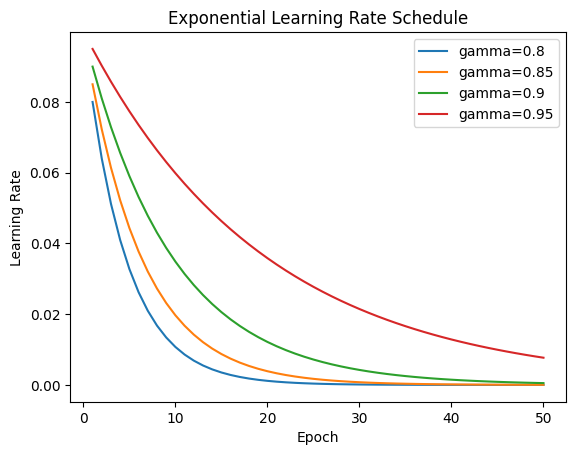

In [ ]:
######################################################################
############################## PLOTTING ##############################
######################################################################
def exponential_schedule(base_lr=0.1, gamma=0.9, num_epochs=50):
    lr = base_lr
    return [lr := lr * gamma for epoch in range(num_epochs)]

epochs = 50
base_lr = 0.1

exp_g08 = exponential_schedule(base_lr=base_lr, gamma=0.8, num_epochs=epochs)
exp_g085 = exponential_schedule(base_lr=base_lr, gamma=0.85, num_epochs=epochs)
exp_g09 = exponential_schedule(base_lr=base_lr, gamma=0.9, num_epochs=epochs)
exp_g095 = exponential_schedule(base_lr=base_lr, gamma=0.95, num_epochs=epochs)

plt.plot(range(1, epochs+1), exp_g08, label='gamma=0.8')
plt.plot(range(1, epochs+1), exp_g085, label='gamma=0.85')
plt.plot(range(1, epochs+1), exp_g09, label='gamma=0.9')
plt.plot(range(1, epochs+1), exp_g095, label='gamma=0.95')

plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Exponential Learning Rate Schedule')
plt.legend();

 To add this scheduler to our model, we will use the same `configure_optimizers` method that we used before to define the scheduler.

In [ ]:
class MultiLayerPerceptronExpLR(MultiLayerPerceptron):

    def configure_optimizers(self, lr=0.1, scheduler_gamma=0.9):

        # Define the optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr)

        # Define the LR scheduler parameters
        # decay rate (gamma) = 0.9 means that at each epoch we will multiply the LR with 0.9
        lr_scheduler_config = {'scheduler': optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma),
                               'interval': 'epoch',  # will the scheduler be triggered at every X 'epoch'(s) or 'step'(s)
                               'frequency': 1}       # every how many epochs/steps will the scheduler be triggered

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}


mlp_explr = MultiLayerPerceptronExpLR(input_dim=2, hidden_dim=30, output_dim=1)

In [ ]:
trainer = L.Trainer(max_epochs=50)

trainer.fit(model=mlp_explr,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

visualize_decision_boundary(mlp_explr)

print(f'Validation accuracy: {trainer.logged_metrics["val_accuracy"]*100:.2f}%')

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | hidden    | Linear          | 90     | train
1 | output    | Linear          | 31     | train
2 | sigmoid   | Sigmoid         | 0      | train
3 | relu      | ReLU            | 0      | train
4 | accuracy  | BinaryAccuracy  | 0      | train
5 | precision | BinaryPrecision | 0      | train
6 | recall    | BinaryRecall    | 0      | train
7 | f1_score  | BinaryF1Score   | 0      | train
8 | auroc     | BinaryAUROC     | 0      | train
------------------------------------------------------
121       Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

There are a lot more options for scheduling, including some more popular options like a cyclical schedule. You can see all available schedulers [here](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

## Callbacks

Before we mentioned that one effect of the trainer is that it abstracts the training loop. This is very convenient in most cases since we don't have to write a lot of boiler plate code, however it limits our control on the training process.

To better understand what's happening, let's look at a rouch outline of what happens inside a training loop:

```python
for epoch in range(num_epochs):  # iterate over the number of epochs

    shuffle(training_set)  # optionally shuffle the training set at the beginning of each epoch
    
    for batch in training_set:   # pass through the training set batch by batch
        x, y = batch             # each batch consists of features and labels
        y_hat = model(x)         # forward propagation
        optimizer.update(model)  # update the model's parameters depending on
                                 # the gradient of the loss between y and y_hat
   
    # After the training phase, at the end of each epoch, run a validation phase
    for x, y in validation_set:
        y_hat = model(x)
        [metric(y, y_hat) for metric in metrics]  # measure each metric on the validation set
```

There are several reasons we might want to interfere in the training loop. Some examples are:
- custom logging
- saving the model every X steps or based on an external condition
- terminating the training loop prematurely based on a condition

While we aren't encouraged to interfere with the training loop in Lightning, it does offer us a mechanism to achieve the same results. Callbacks are essentially methods of *hooking* intro the training loop at specific points and performing custom actions. We won't delve into how to create custom callbacks, rather we'll focus on the [built-in ones](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html#built-in-callbacks).

Callbacks are configured in the [`configure_callbacks`](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#configure-callbacks) method of the `LightningModule`.

### Model Checkpoint

The first we'll examine is [`ModelCheckpoint`](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelCheckpoint.html#lightning.pytorch.callbacks.ModelCheckpoint). This offers a flexible way to store the model during training. There are basically two methods for saving our weights:

1. Save on a **regular interval** (i.e. every N epochs or training steps). This can be controlled by the parameters `every_n_epochs` and `every_n_train_steps`. `save_last` will save the last model regardless.
2. Save on a **condition**. This can be controlled by the following mechanism:
  - `monitor`: define a metric that will be monitored (e.g. 'val_loss', 'train_accuracy').
  - `mode`: define which is the best value for the monitored metric (e.g. for loss the 'min' value produces the best model, while for accuracy it's the 'max').
  - `save_top_k`: choose how many of the *best* models to save (default is 1).

In [ ]:
class MultiLayerPerceptronChkp(MultiLayerPerceptronExpLR):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

        # It's useful to save the model's hyperparameters
        # so we won't need to re-define them when loading the model
        self.save_hyperparameters()

    def configure_callbacks(self):

        # Define the ModelCheckpoint callback
        model_checkpoint = ModelCheckpoint(dirpath='models',
                                   filename='{epoch}-{val_accuracy:.2f}',
                                   monitor='val_accuracy',  # monitor the validation accuracy
                                   mode='max',              # decide the best model based on the 'max'
                                   save_top_k=1)            # save only the best model

        return model_checkpoint

mlp_chkp = MultiLayerPerceptronChkp(input_dim=2, hidden_dim=30, output_dim=1)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name      | Type            | Params | Mode
-----------------------------------------------------
0 | hidden    | Linear          | 90     | eval
1 | output    | Linear          | 31     | eval
2 | sigmoid   | Sigmoid         | 0      | eval
3 | relu      | ReLU            | 0      | ev

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Validation accuracy: 100.00%


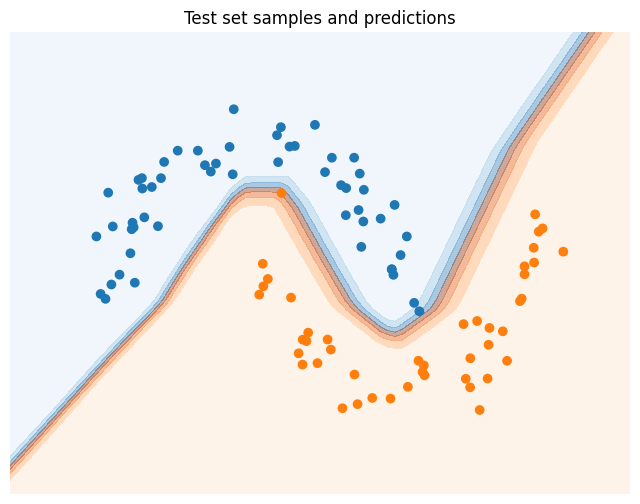

In [ ]:
trainer = L.Trainer(max_epochs=50)

trainer.fit(model=mlp_chkp,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

visualize_decision_boundary(mlp_chkp)

print(f'Validation accuracy: {trainer.logged_metrics["val_accuracy"]*100:.2f}%')

If we look at our CWD, we'll see that a new directory called `models` has been created with the best model stored there.

In [ ]:
!ls models

'epoch=10-val_accuracy=1.00.ckpt'  'epoch=9-val_accuracy=0.97.ckpt'
'epoch=12-val_accuracy=0.98.ckpt'   model_weights.pth


## Case Study: Regularization

With the knowledge we have of Lightning up till now, let's try to examine the following case study: let's say our model is overfitting and we want to implement some regularization method on in. How can we regularize a neural network? The 3 most popular methods are the following:

- **L1/L2 regularization**: apply a penalty on the norm of the model's parameters.
- **Early stopping**: terminate the model prematurely when a condition is met (e.g. some validation metric stops improving).
- **Dropout**: a neural network specific technique where we randomly drop some connections at each step.

What is interesting is that these 3 techniques are applied all in different stages of creating the model:

- L2 regularization is defined as a parameter of the optimizer (i.e. `weight_decay`).
- Early stopping is defined as a callback (i.e. [`EarlyStopping`](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.EarlyStopping.html#lightning.pytorch.callbacks.EarlyStopping)).
- Dropout is defined as a layer in the network (i.e. [`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)).

_**Important note**: In practice we probably wouldn't want to apply all these 3 techniques together, however here we'll do it to showcase how each one works._

In [ ]:
class MultiLayerPerceptronRegularization(MultiLayerPerceptronChkp):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
        self.dropout = nn.Dropout(p=0.5)  # dropout with 50% probability

    def forward(self, x):
        """
        Define the forward propagation of the model
        """
        x = self.relu(self.hidden(x))
        x = self.dropout(x)  # apply the dropout after the hidden layer's output
        x = self.sigmoid(self.output(x))
        return x

    def configure_callbacks(self):

        # Define the same ModelCheckpoint we had before
        model_checkpoint = ModelCheckpoint(dirpath='models',
                                           filename='{epoch}-{val_accuracy:.2f}',
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_top_k=1)

        # Also define an EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss',  # monitor the validation loss
                                       mode='min',          # a better loss is the one with the 'min' value
                                       min_delta=0.01,      # minimum change of the loss that will constitute an improvement
                                       patience=5)          # min_delta condition should be true for 5 iterations in a row to terminate training


        return [model_checkpoint, early_stopping]  # return a list of callbacks if we have more than 1

    def configure_optimizers(self, lr=0.1, scheduler_gamma=0.9, weight_decay=1e-4):

        # L2 regularization (i.e. 'weight decay') is added as a parameter to the optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        lr_scheduler_config = {'scheduler': optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma),
                               'interval': 'epoch',
                               'frequency': 1}

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}


mlp_reg = MultiLayerPerceptronRegularization(input_dim=2, hidden_dim=30, output_dim=1)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:lightning.pytorch.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: 
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | hidden    | Linear          | 90     | train
1 | output    | Linear          | 31     | train
2 | sigmoid   | Sigmoid         | 0      | train
3 | relu      | ReLU            | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation accuracy: 96.97%


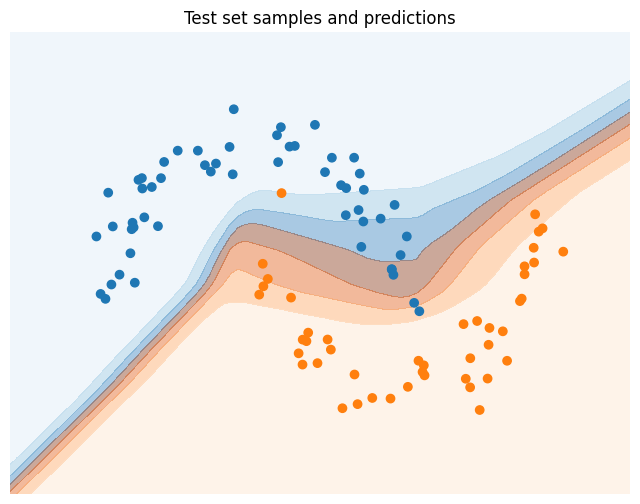

In [ ]:
trainer = L.Trainer(max_epochs=50)

trainer.fit(model=mlp_reg,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

visualize_decision_boundary(mlp_reg)

print(f'Validation accuracy: {trainer.logged_metrics["val_accuracy"]*100:.2f}%')

# Saving and Loading Torch Models

There are two main ways of saving models:

1. Using a **model checkpoint** (i.e. the way we saw before with the callback).
2. **Manually** saving the model's `state_dict`.

_**Important note**: Saving the `state_dict` essentially only stores the model's **weights**. This is often sufficient if we want to load the model for inference or for finetuning, etc. However, if we want to resume training from where it left off we'll often need more things (the state of the optimizers, schedulers, etc.). In these cases we'll also need to save the `state_dict` of the optimizer, scheduler, etc._

## Model Checkpoints

We saw how we can store a model using a checkpoint, let's now see how we can load it.

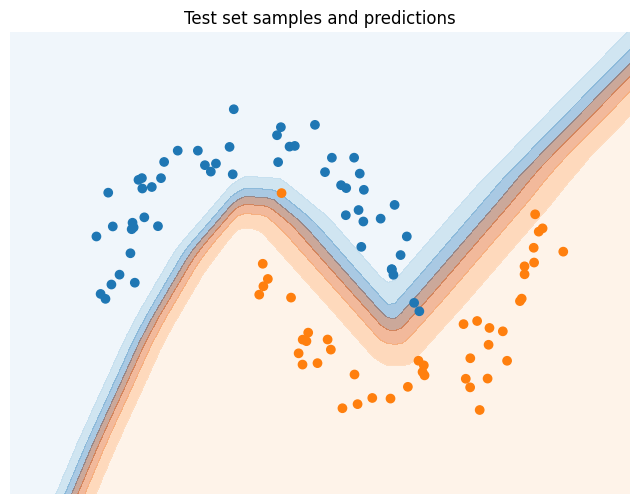

In [ ]:
checkpoint = os.path.join('models', [m for m in os.listdir('models') if m.endswith('.ckpt')][0])

model = MultiLayerPerceptronRegularization.load_from_checkpoint(checkpoint)

# It's also technically possible to overwrite hyperparameters during initialization
# (if these aren't actually changing the model's architecture like they are here)
# model = MultiLayerPerceptronRegularization.load_from_checkpoint(checkpoint, input_dim=2, hidden_dim=30, output_dim=1)

visualize_decision_boundary(model)

### Manual saving

To save the model's `state_dict`:

In [ ]:
torch.save(mlp_reg.state_dict(), 'models/model_weights.pth')

To load the model we'll first need to initialize it and then load the `state_dict` we saved onto this new model.

<ipython-input-27-6c03215ef760>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('models/model_weights.pth'))


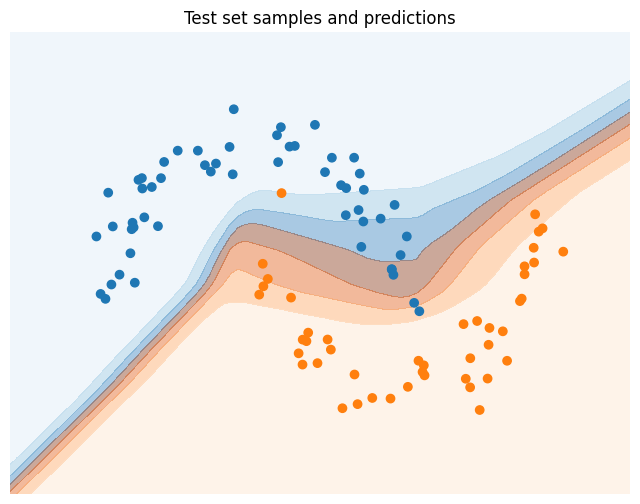

In [ ]:
model2 = MultiLayerPerceptronRegularization(input_dim=2, hidden_dim=30, output_dim=1)

model2.load_state_dict(torch.load('models/model_weights.pth'))

visualize_decision_boundary(model2)